In [2]:
%load_ext autoreload
%autoreload 2

# --------------------------------------------------------------------------------

import os
import sys
from pathlib import Path
import numpy as np
np.warnings.filterwarnings('ignore')

# hex2cec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{os.environ['HOME']}/hex2vec")
sys.path.insert(0, f"{os.environ['HOME']}/amazon-routing-challenge")

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
import urban_tools.hex_pipeline as hp
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd
import h3
import gcsfs

%matplotlib inline
import matplotlib.pyplot as plt
## Read in the DataFrame

p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/12.12.22-Revised-Embeddings/hh.pkl")
hh = RouteHexHandler.from_pickle(p)
hh.print_history()
hh = hh.drop_zero_tags()
### Drop Tags that occur in <X% of a City
# percentage = 0.01
# import pandas as pd

# drop_cols = pd.Index([])
# for _hh in [hh]:
#     assert _hh.df["city"].unique().shape[0] == 1
#     h3_df = _hh.df.groupby('h3')[_hh.all_tags].first()
#     percent_occurance = (h3_df > 0).sum() / h3_df.shape[0]
#     drop_cols = drop_cols.union(percent_occurance[percent_occurance < percentage].index)
# hh.drop_cols(drop_cols)
# len(hh.all_tags)
### Append the embedding to the dataframe
# embedding_df = pd.read_parquet(
#     hh.my_folder / "embeddings.prq"
# )
embedding_df = pd.read_feather(
    "/gcsmount-research-data-staging/hex2vec-models/paper-final/embedding_dfs/subtags+cities+littlemodel.feather"
)
embedding_df = embedding_df.set_index("h3")
# embedding_df.columns = [f"e_{e}" for e in embedding_df.columns]
# embedding_df = embedding_df[embedding_df.columns.str.]
# embedding_columns = embedding_df.columns.copy()
# embedding_df = embedding_df.reset_index()

hh.df = hh.df.merge(embedding_df, on="h3", how="left")
hh.update_tags()
hh.df = hh.df.dropna(subset=hh.embeddings)
### Filter for only H3 with > X Data Points

# tagged_df = tagged_df.loc[tagged_df["h3_9"] > 20].copy()
hh.df = hh.df[hh.df.city.str.contains('Boston')]
hh = hh.filter_hex_occurance(20)
# hh.df.drop("h3_9", axis=1, inplace=True)
# print(tagged_df.shape)
hh.df = hh.df.reset_index(drop=True)

read_cities(*(PosixPath('/gcsmount-research-data-staging/osmnx-cities/hexed-complete'),), **{'cities': ['Boston, USA', 'Austin, USA', 'Seattle, USA', 'Los Angeles, USA'], 'add_city_col': True})
create_super_tags(*(), **{})
Merge building_residential + building_house -> building_yes(*(), **{})
drop_zero_buildings(*(), **{})
drop_zero_building_area(*(), **{})
add_new_special_tag(*('building.area.average',), **{})
add_new_special_tag(*('parking.area.average',), **{})
append_route_df(*(), **{'grouped': False, 'tukey_fences': False})
open_route_df(*(), **{'grouped': False, 'tukey_fences': False})
drop_zero_tags(*(), **{})


### Create the TT Manager

In [3]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from scipy.stats import pearsonr

In [4]:
tt = TestTrainManager(
    hh.df,
    x_col=hh.embeddings.union(hh.special_tags).union(hh.super_tags),
    y_col=["planned_service_time_log"],
    scaler=RobustScaler,
    grouped=False,
    desired_quantiles=[0.5, 0.90]
)

tt.split_test_train(train_size=0.8, random_seed=42)
tt.scale_test_train()
# split the tt.X_test into several chunks. Have to do this because of memory issues
tt.build_test_df(agg=False)

In [5]:
X_train, y_train, X_test, y_test = tt.X_train.values, tt.Y_train.planned_service_time_log.values.ravel(), tt.X_test.values, tt.Y_test.loc.values
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, y_train = tt.X_train.values, tt.Y_train.values

In [6]:
X_train.shape, X_cal.shape, X_test.shape

((14135, 74), (2827, 74), (3347, 74))

In [7]:
from typing_extensions import TypedDict
from typing import Union
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    RobustScaler
)
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner, default_linear_learner
from ngboost.scores import CRPS, MLE 
from ngboost.distns import LogNormal, Normal

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

warnings.filterwarnings("ignore")

In [8]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense
# from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor

# def mlp():
#     """
#     Dense MLP model
#     """
#     model = Sequential([
#         Dense(units=20, input_shape=(1,), activation="relu"),
#         Dense(units=20, activation="relu"),
#         Dense(units=1)
#     ])
#     model.compile(loss="mean_squared_error", optimizer="adam")
#     return model

# mlp_model = KerasRegressor(
#     build_fn=mlp,
#     epochs=500
# )

mlp = MLPRegressor(
    hidden_layer_sizes=[16, 32, 128, 32, 16],
    max_iter=1000,
    activation='relu',
    solver='adam',
    learning_rate='constant',
    learning_rate_init=1e-3,
    random_state=12323,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.2,
)
	


In [9]:
def get_regressor(name):
    if name == "xgboost":
        mdl = XGBRegressor()
    elif name == "ngboost":
        mdl = NGBRegressor(
            n_estimators=1000,
            learning_rate=1e-3,
            Dist=Normal,
            Base=default_tree_learner,
            natural_gradient=True,
            # minibatch_frac=1.0,
            Score=MLE,
            # minibatch_frac=0.5, 
            # col_sample=0.5
        )
    elif name == "nn":
        mdl = MLPRegressor(
            hidden_layer_sizes=[16, 32, 128, 32, 16],
            max_iter=1000,
            activation='relu',
            solver='adam',
            learning_rate='adaptive',
            learning_rate_init=1e-3,
            random_state=12323,
            verbose=True,
            early_stopping=True,
            validation_fraction=0.2,
        )
    elif name == "random_forest":
        mdl = RandomForestRegressor()
    return mdl

### Testing for a specific regressor

In [10]:
mdl = get_regressor("random_forest")
mapie = MapieRegressor(mdl, method="plus", cv=KFold(n_splits=2, shuffle=True)).fit(X_cal, y_cal)

In [11]:
mapie.fit(X_train, y_train)

MapieRegressor(cv=KFold(n_splits=2, random_state=None, shuffle=True),
               estimator=RandomForestRegressor())

In [12]:
alpha = np.arange(0.05, 1, 0.05)
y_train_pred, y_train_pis = mapie.predict(X_train, alpha=alpha)
y_test_pred, y_test_pis = mapie.predict(X_test, alpha=alpha)

In [13]:
def plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pred_low,
    y_train_pred_high,
    y_test,
    y_test_pred,
    y_test_pred_low,
    y_test_pred_high,
    suptitle: str,
) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    ax1.errorbar(
        x=y_train,
        y=y_train_pred,
        yerr=(y_train_pred - y_train_pred_low, y_train_pred_high - y_train_pred),
        alpha=0.8,
        label="train",
        fmt=".",
    )
    ax1.errorbar(
        x=y_test,
        y=y_test_pred,
        yerr=(y_test_pred - y_test_pred_low, y_test_pred_high - y_test_pred),
        alpha=0.8,
        label="test",
        fmt=".",
    )
    ax1.plot(
        [y_train.min(), y_train.max()],
        [y_train.min(), y_train.max()],
        color="gray",
        alpha=0.5,
    )
    ax1.set_xlabel("True values", fontsize=12)
    ax1.set_ylabel("Predicted values", fontsize=12)
    ax1.legend()
    
    ax2.scatter(
        x=y_train, y=y_train_pred_high - y_train_pred_low, alpha=0.8, label="train", marker="."
    )
    ax2.scatter(x=y_test, y=y_test_pred_high - y_test_pred_low, alpha=0.8, label="test", marker=".")
    ax2.set_xlabel("True values", fontsize=12)
    ax2.set_ylabel("Interval width", fontsize=12)
    ax2.set_xscale("linear")
    ax2.set_ylim([0, np.max(y_test_pred_high - y_test_pred_low)*1.1])
    ax2.legend()
    std_all = np.concatenate([
        y_train_pred_high - y_train_pred_low, y_test_pred_high - y_test_pred_low
    ])
    type_all = np.array(["train"] * len(y_train) + ["test"] * len(y_test))
    x_all = np.arange(len(std_all))
    order_all = np.argsort(std_all)
    std_order = std_all[order_all]
    type_order = type_all[order_all]
    ax3.scatter(
        x=x_all[type_order == "train"],
        y=std_order[type_order == "train"],
        alpha=0.8,
        label="train",
        marker=".",
    )
    ax3.scatter(
        x=x_all[type_order == "test"],
        y=std_order[type_order == "test"],
        alpha=0.8,
        label="test",
        marker=".",
    )
    ax3.set_xlabel("Order", fontsize=12)
    ax3.set_ylabel("Interval width", fontsize=12)
    ax3.legend()
    ax1.set_title("True vs predicted values")
    ax2.set_title("Prediction interval width vs true values")
    ax3.set_title("Ordered prediction interval width")
    plt.suptitle(suptitle, size=20)
    plt.show()

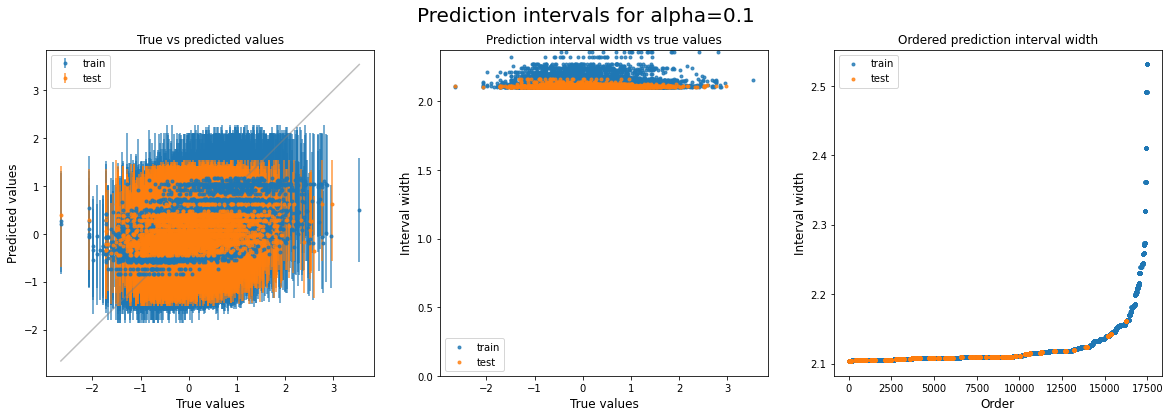

In [14]:
alpha_plot = int(np.where(alpha == 0.1)[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    "Prediction intervals for alpha=0.1",
)

## Comparison of the uncertainty quantification methods

* get empirical points for every hexagon!

In [15]:
# h3_index = hh.df.loc[tt._test_slice, 'h3']
# test_df = tt.Y_test.loc.groupby(h3_index).agg({'mean', 'std'})
# y_test_std = test_df['std']

# empirical_pts_df = hh.df.loc[hh.df['h3'].isin(test_df.index)].groupby('h3').apply(lambda x: x['planned_service_time'].values)
# empirical_pts_df = empirical_pts_df[test_df.index]

def get_empirical_pnts(case, alpha):
    if case == "Train":
        h3_index = hh.df.loc[tt._train_slice, 'h3']
        df = tt.Y_train.groupby(h3_index).agg({'mean', 'std'})
        # get the inverse transform of the y_pred
        # y_data = pd.DataFrame(data=np.exp(tt.scaler.Y.inverse_transform(tt.Y_train.values.reshape(-1, 1)).reshape(-1)), index=h3_index, columns=['y'])
        y_data = pd.DataFrame(data=tt.Y_train.values, index=h3_index, columns=['y'])
        # True upper and lower quantiles  
        scaled_true_lb = tt.Y_train.groupby(h3_index).apply(lambda x: np.quantile(x, alpha/2))
        scaled_true_ub = tt.Y_train.groupby(h3_index).apply(lambda x: np.quantile(x, 1-alpha/2))
    else:
        h3_index = hh.df.loc[tt._test_slice, 'h3']
        df = tt.Y_test.loc.groupby(h3_index).agg({'mean', 'std'})
        # get the inverse transform of the y_pred
        # y_data = pd.DataFrame(data=np.exp(tt.scaler.Y.inverse_transform(tt.Y_test.loc.values.reshape(-1, 1)).reshape(-1)), index=h3_index, columns=['y'])
        y_data = pd.DataFrame(data=tt.Y_test.loc.values, index=h3_index, columns=['y'])
        # True upper and lower quantiles  
        scaled_true_lb = tt.Y_test.loc.groupby(h3_index).apply(lambda x: np.quantile(x, alpha/2))
        scaled_true_ub = tt.Y_test.loc.groupby(h3_index).apply(lambda x: np.quantile(x, 1-alpha/2))
    y_data.reset_index(inplace=True)
    empirical_pts_df = hh.df.loc[hh.df['h3'].isin(df.index)].groupby('h3').apply(lambda x: x['planned_service_time'].values)
    return y_data, empirical_pts_df[df.index], scaled_true_lb, scaled_true_ub


##### calculate standard deviation (`std`) using empirical points inside every hexagon!

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import plotly.express as px
import plotly.graph_objects as go

def get_test_predicted_intervals(mapie, y_pred, y_pred_lb, y_pred_ub, alpha, case):
    
    scores = {}

    # get relevant y data based on the case
    y_data, empirical_pts_df, scaled_true_lb, scaled_true_ub = get_empirical_pnts(case, alpha)

    # In true scale
    # y_data['y_pred'] = np.exp(tt.scaler.Y.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1))
    # y_data['y_pred_lb'] = np.exp(tt.scaler.Y.inverse_transform(y_pred_lb.reshape(-1, 1)).reshape(-1))
    # y_data['y_pred_ub'] = np.exp(tt.scaler.Y.inverse_transform(y_pred_ub.reshape(-1, 1)).reshape(-1))

    y_data['y_pred'] = y_pred
    y_data['y_pred_lb'] = y_pred_lb
    y_data['y_pred_ub'] = y_pred_ub

    # get the y_pred_df
    y_pred_df = y_data.groupby('h3')[['y_pred', 'y_pred_lb', 'y_pred_ub']].first()
    y_pred_df['y'] = y_data.groupby('h3')['y'].mean()
    # In true scale
    # y_pred_df['y_true_lb'] = [np.quantile(x, alpha/2) for x in empirical_pts_df.values]
    # y_pred_df['y_true_ub'] = [np.quantile(x, 1-alpha/2) for x in empirical_pts_df.values]

    scores['coverage-score'] = np.round(regression_coverage_score(y_data['y'], y_pred_lb, y_pred_ub), 3)
    scores['mean'], scores['lower-quantile'], scores['upper-quantile'] = {}, {}, {}
    # get the scores for the mean
    scores['mean']['MAPE'] = np.round(mean_absolute_percentage_error(y_pred_df['y'], y_pred_df['y_pred']), 3)
    scores['mean']['R2'] = np.round(r2_score(y_pred_df['y'], y_pred_df['y_pred']), 3)
    scores['mean']['RMSE'] = np.round(mean_squared_error(y_pred_df['y'], y_pred_df['y_pred'], squared=False), 3)
    # get the scores for the lower quantile
    scores['lower-quantile']['MAPE'] = np.round(mean_absolute_percentage_error(scaled_true_lb, y_pred_df['y_pred_lb']), 3)
    scores['lower-quantile']['R2'] = np.round(r2_score(scaled_true_lb, y_pred_df['y_pred_lb']), 3)
    scores['lower-quantile']['RMSE'] = np.round(mean_squared_error(scaled_true_lb, y_pred_df['y_pred_lb'], squared=False), 3)
    # get the scores for the upper quantile
    scores['upper-quantile']['MAPE'] = np.round(mean_absolute_percentage_error(scaled_true_ub, y_pred_df['y_pred_ub']), 3)
    scores['upper-quantile']['R2'] = np.round(r2_score(scaled_true_ub, y_pred_df['y_pred_ub']), 3)
    scores['upper-quantile']['RMSE'] = np.round(mean_squared_error(scaled_true_ub, y_pred_df['y_pred_ub'], squared=False), 3)
    
    # print(f"Test Mean: MAPE= {mean_absolute_percentage_error(y_pred_df['y_test'], y_pred_df['y_test_mean_pred']):.3f}, Test RMSE= {mean_squared_error(y_pred_df['y_test'], y_pred_df['y_test_mean_pred'], squared=False):.3f}, Test R2= {r2_score(y_pred_df['y_test'], y_pred_df['y_test_mean_pred']):.3f}")
    # print(f"Test lower Quantile: MAPE= {mean_absolute_percentage_error(scaled_true_lb, y_pred_df['y_pred_lb']):.3f}, Test RMSE: {mean_squared_error(scaled_true_lb, y_pred_df['y_pred_lb'], squared=False):.3f}, Test R2: {r2_score(scaled_true_lb, y_pred_df['y_pred_lb']):.3f}")
    # print(f"Test Upper Quantile: MAPE= {mean_absolute_percentage_error(scaled_true_ub, y_pred_df['y_pred_ub']):.3f}, Test RMSE: {mean_squared_error(scaled_true_ub, y_pred_df['y_pred_ub'], squared=False):.3f}, Test R2: {r2_score(scaled_true_ub, y_pred_df['y_pred_ub']):.3f}")
    # print('-'*70)   
    return scores

* All selected methods for comparison

In [22]:
h3_index = hh.df.loc[tt._train_slice, 'h3']
train_y_data = pd.DataFrame(data=tt.X_train.values, index=h3_index, columns=tt.X_train.columns)
train_y_data

,aeroway,amenity,building,building.area,building.area.average,building.area.ratio,e_0,e_1,e_10,e_11,...,parking.area.average,parking.area.ratio,public_transport,railway,route,shop,sport,tourism,water,waterway
h3,,,,,,,,,,,,,,,,,,,,,
892a339a483ffff,0.0,-0.166667,-0.547368,-0.529146,0.365502,-0.528609,0.466216,0.105333,0.477003,0.010592,...,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892a339a49bffff,0.0,-0.166667,-0.557895,-0.605759,0.244523,-0.605491,0.080909,0.065615,1.280904,0.207649,...,0.0,0.0,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892a339a49bffff,0.0,-0.166667,-0.557895,-0.605759,0.244523,-0.605491,0.080909,0.065615,1.280904,0.207649,...,0.0,0.0,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892a339a493ffff,0.0,-0.166667,-0.926316,-1.253889,-0.449345,-1.255273,-0.176347,-1.478979,-0.362286,0.235867,...,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892a339a493ffff,0.0,-0.166667,-0.926316,-1.253889,-0.449345,-1.255273,-0.176347,-1.478979,-0.362286,0.235867,...,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892a339164fffff,0.0,-0.166667,-1.357895,-0.870870,3.017987,-0.870725,-1.520522,-0.510880,-0.393947,0.356573,...,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0
892a339a5a3ffff,0.0,-0.166667,-0.800000,-0.945080,0.041889,-0.945132,-0.755880,-0.157014,-0.112975,-0.345022,...,0.0,0.0,-1.000000,22.0,0.0,0.0,4.0,0.0,0.0,0.0
892a339a5b7ffff,0.0,-0.333333,-0.189474,-0.842703,-0.647554,-0.842426,-0.073659,-0.973235,0.000000,0.582006,...,0.0,0.0,-1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
class custom_KFold(KFold):
    def __init__(self, n_splits=5, shuffle=False, random_state=None, groups=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        self.groups = groups
        
    def split(self, X, y=None, groups=None):
        if self.groups is None:
            raise ValueError("The 'groups' parameter should not be None.")
        return super().split(X, y, self.groups)

In [29]:
Params = TypedDict("Params", {"method": str, "cv": Union[int, Subsample]})
STRATEGIES = {
    # "ngboost": Params(method="plus", cv=KFold(n_splits=2, groups = h3_index, shuffle=True)),
    "random_forest": Params(method="plus", cv=custom_KFold(n_splits=2, shuffle=True, groups = h3_index)),
    # "xgboost": Params(method="plus", cv=KFold(n_splits=2, groups = h3_index, shuffle=True)),
    # "nn": Params(method="plus", cv=KFold(n_splits=2, groups = h3_index, shuffle=True)),
}

In [30]:
y_pred, y_pis, scores = {}, {}, {}
cases = ["Train", "Test"]
variables = ['mean', 'lower-quantile', 'upper-quantile']
metrics = ['MAPE', 'RMSE', 'R2']

# Initialize dictionaries
for strategy in STRATEGIES.keys():
    y_pred[strategy], y_pis[strategy], scores[strategy] = {}, {}, {}
    for case in cases:
        y_pred[strategy][case], y_pis[strategy][case], scores[strategy][case] = [], [], []
        # for variable in variables:
        #     scores[strategy][case][variable] = {}
        #     for metric in metrics:
        #         scores[strategy][case][variable][metric] = []

# Looping over
for strategy, params in STRATEGIES.items():
    mdl = get_regressor(strategy)
    mapie = MapieRegressor(mdl, **params).fit(X_cal, y_cal)
    mapie.fit(X_train, y_train)
    print(f'{strategy} fitted!')
    
    for case in cases:
        if case == "Train":
            y_pred[strategy][case], y_pis[strategy][case] = mapie.predict(X_train, alpha=alpha)
        else:
            y_pred[strategy][case], y_pis[strategy][case] = mapie.predict(X_test, alpha=alpha)
            # scores[strategy]['coverage-score'] = [
            #             regression_coverage_score(y_test, y_pis[strategy][case][:, 0, i], y_pis[strategy][case][:, 1, i])
            #             for i, _ in enumerate(alpha)
            #         ]
        scores[strategy][case] = [get_test_predicted_intervals(mapie, y_pred[strategy][case], y_pis[strategy][case][:, 0, i], y_pis[strategy][case][:, 1, i], alpha[i], case)
                    for i, _ in enumerate(alpha)]

ValueError: Found input variables with inconsistent numbers of samples: [2827, 14135]

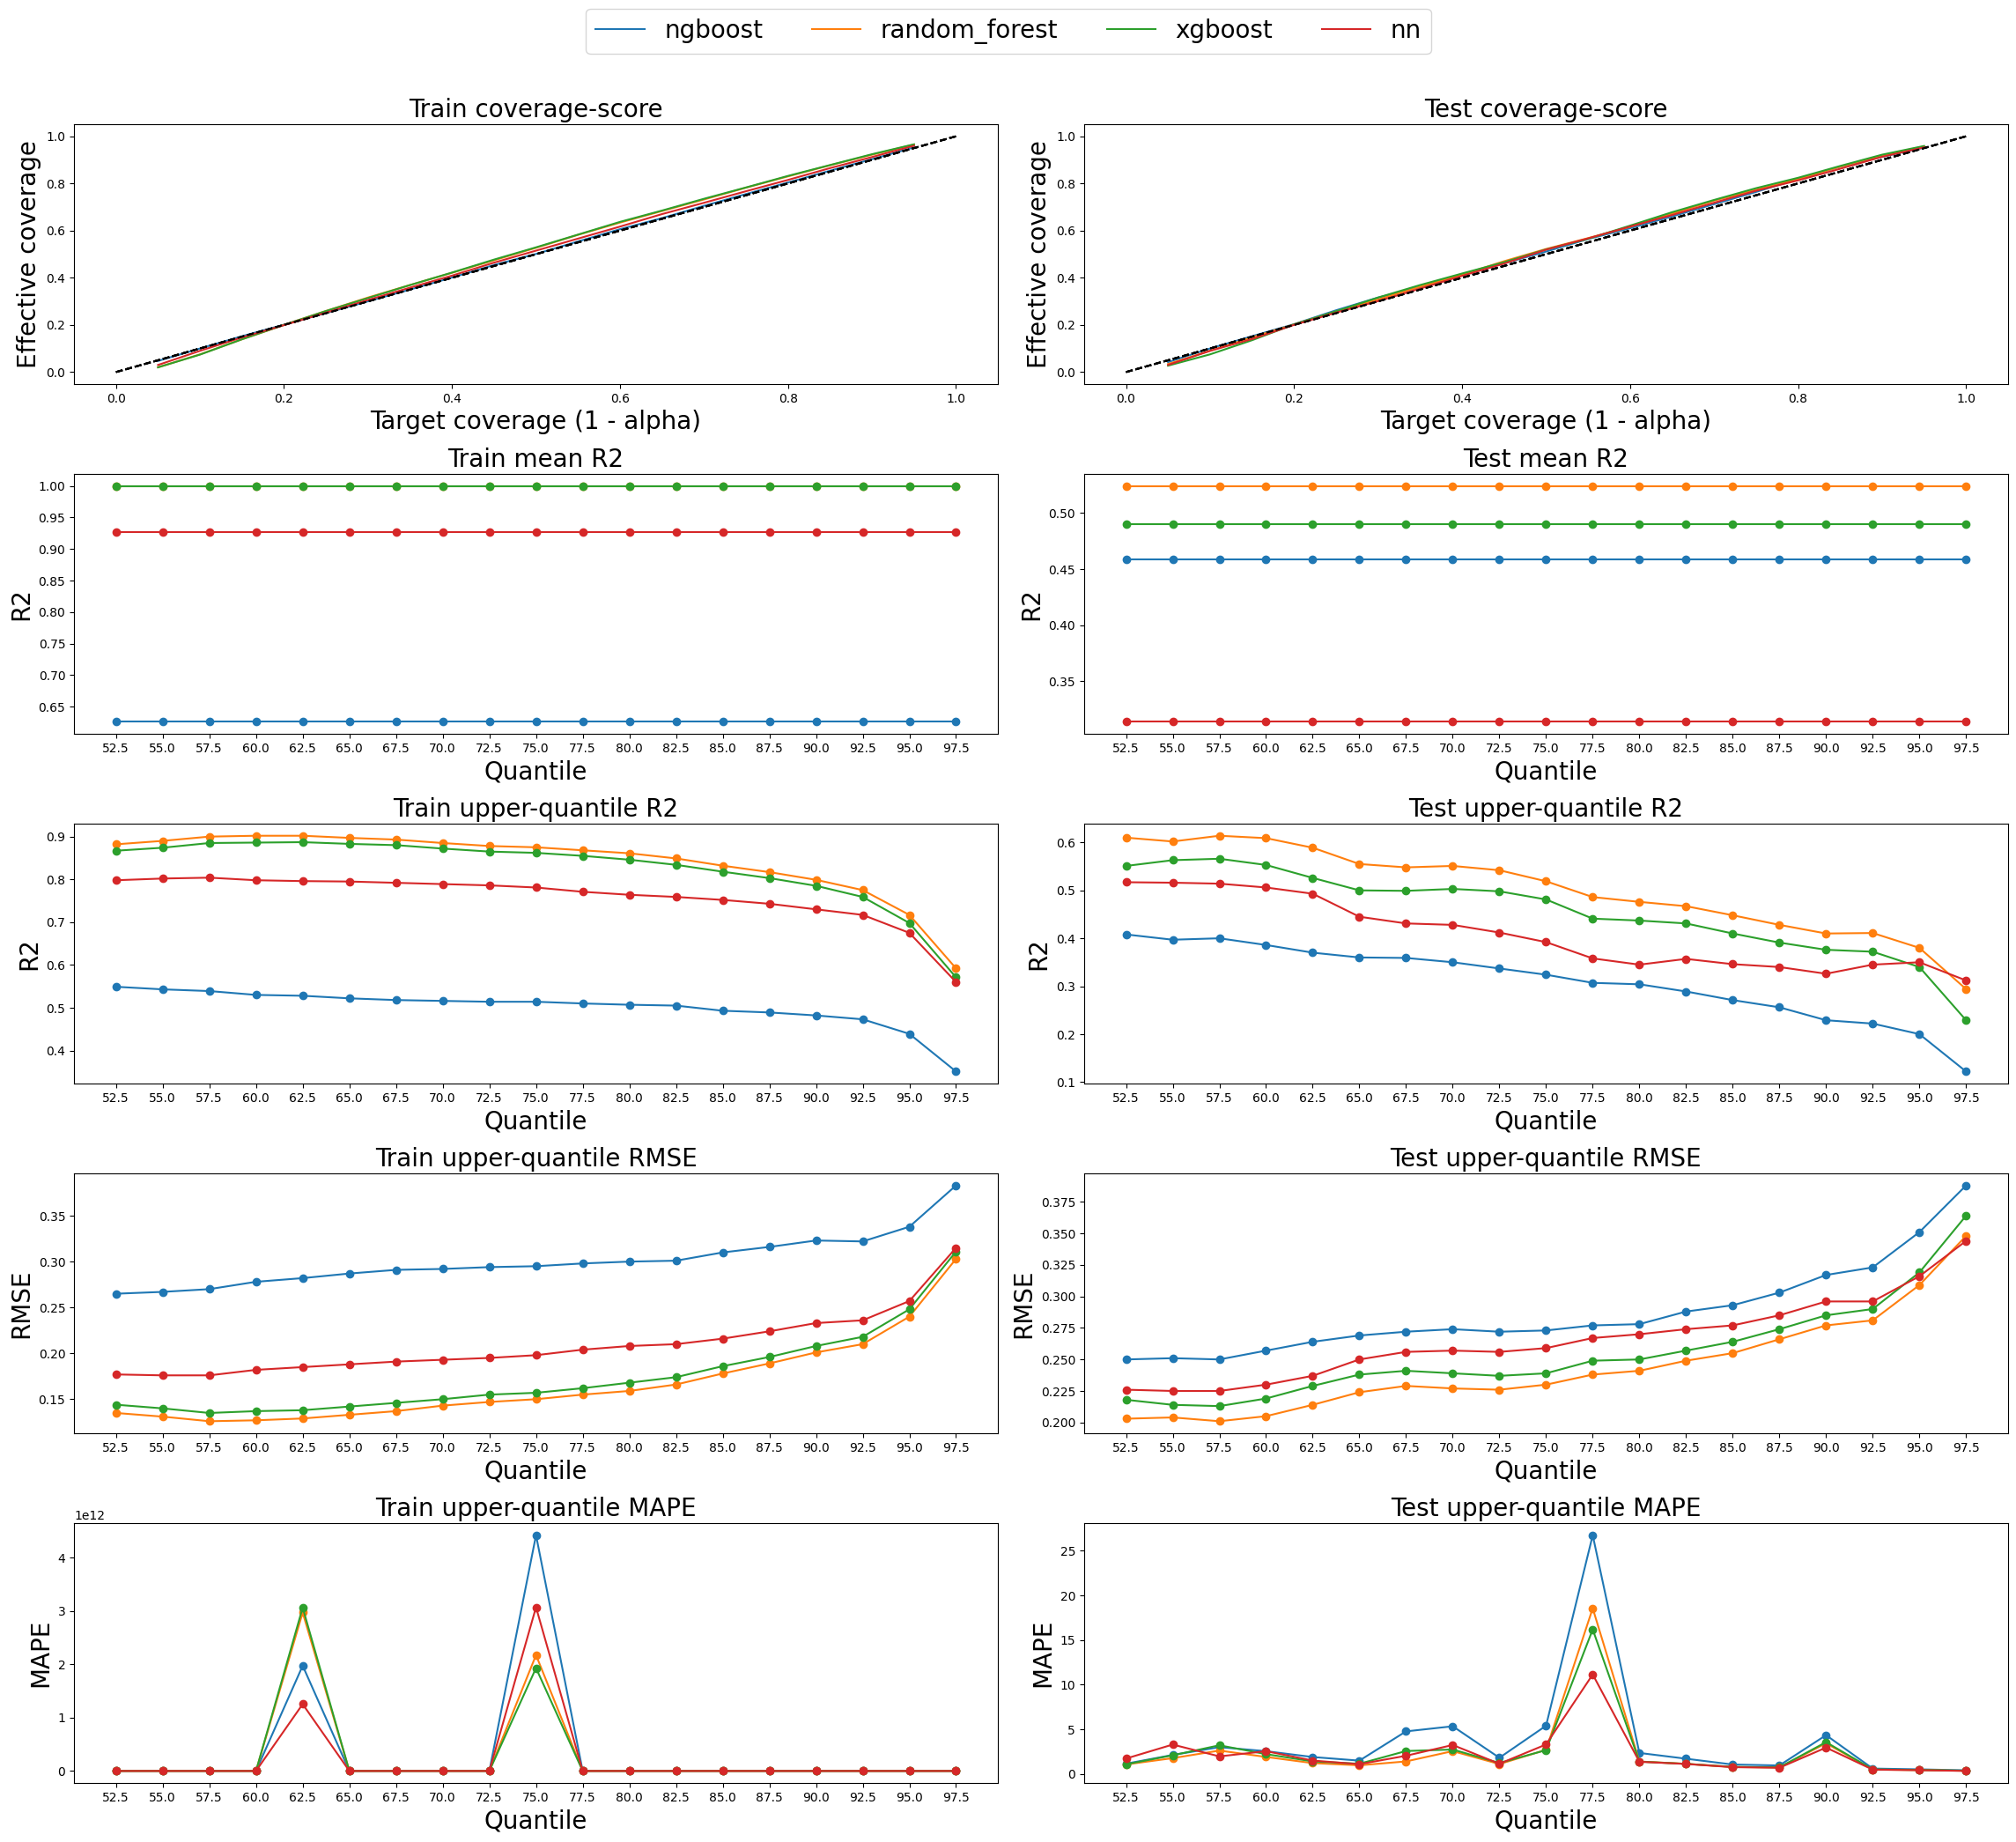

In [ ]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

def plot_along_axes(case, metric, variable=None, ax=None, **kwargs):
    ax.set_ylabel("Effective coverage")
    for strategy, params in STRATEGIES.items():
        if metric == 'coverage-score':
            ax.set_xlabel("Target coverage (1 - alpha)", fontsize = 20.0)
            ax.plot(1 - alpha, [scores[strategy][case][i]['coverage-score'] for i,_ in enumerate(alpha)], label=strategy)
            ax.plot([0, 1], [0, 1], ls="--", color="k")
            ax.set_title(f"{case} {metric}", size=20)
            ax.set_ylabel("Effective coverage", fontsize = 20.0)

        else:
            ax.set_xlabel("Quantile", fontsize = 20.0)
            ax.set_xticks((1 - alpha/2)*100,  fontsize = 20.0)
            ax.plot((1 - alpha/2)*100, [scores[strategy][case][i][variable][metric] for i,_ in enumerate(alpha)], label=strategy, marker = 'o')
            ax.set_title(f"{case} {variable} {metric}", size = 20.0)
            ax.set_ylabel(metric, fontsize = 20.0)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,2, figsize=(23, 20))
plot_along_axes(case='Train', metric='coverage-score', ax=ax1[0])
plot_along_axes(case='Test', metric='coverage-score', ax=ax1[1])
# ax1.set_legend(loc=[1, 0])
plot_along_axes(case='Train', metric='R2', variable='mean', ax=ax2[0])
plot_along_axes(case='Test', metric='R2', variable='mean', ax=ax2[1])
plot_along_axes(case='Train', metric='R2', variable='upper-quantile', ax=ax3[0])
plot_along_axes(case='Test', metric='R2', variable='upper-quantile', ax=ax3[1])
plot_along_axes(case='Train', metric='RMSE', variable='upper-quantile', ax=ax4[0])
plot_along_axes(case='Test', metric='RMSE', variable='upper-quantile', ax=ax4[1])
plot_along_axes(case='Train', metric='MAPE', variable='upper-quantile', ax=ax5[0])
plot_along_axes(case='Test', metric='MAPE', variable='upper-quantile', ax=ax5[1])

fig.legend(*ax1[0].get_legend_handles_labels(),
            loc='upper center', ncol=8, bbox_to_anchor=(.5, 1.05), fontsize = 20.0)

plt.tight_layout()
plt.show()

### Create a table with all the results